In [ ]:
!unzip "drive/MyDrive/apple_new.zip"

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
Channels = 3
EPOCHS = 30
INPUT_SHAPE = (IMG_SIZE , IMG_SIZE , Channels)

In [30]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Apple",
    shuffle = True,
    image_size = (IMG_SIZE , IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 2635 files belonging to 3 classes.


In [31]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy']

In [32]:
def get_dataset_partitions_tf(ds , train_split = 0.8,val_split=0.1,test_split=0.1,shuffle=True ,shuffle_size=1000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds , val_ds , test_ds

In [33]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [34]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [35]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [37]:
vgg = tf.keras.applications.VGG16(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [38]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [39]:
n_classes = 3
model = tf.keras.Sequential()
model.add(resize_and_rescale)
model.add(data_agumentation)
model.add(vgg)
model.add(Flatten())
model.add(Dense(n_classes,activation='softmax'))
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, Channels))

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14789955 (56.42 MB)
Trainable params: 75267 (294.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14789955 (56.42 MB)
Trainable params: 75267 (294.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [42]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    epochs = 25,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
66/66 [==============================] - 18s 219ms/step - loss: 0.5206 - accuracy: 0.8054 - val_loss: 0.1336 - val_accuracy: 0.9531
Epoch 2/25
66/66 [==============================] - 10s 158ms/step - loss: 0.1250 - accuracy: 0.9627 - val_loss: 0.1190 - val_accuracy: 0.9648
Epoch 3/25
66/66 [==============================] - 10s 158ms/step - loss: 0.0874 - accuracy: 0.9766 - val_loss: 0.0561 - val_accuracy: 0.9883
Epoch 4/25
66/66 [==============================] - 10s 150ms/step - loss: 0.0575 - accuracy: 0.9876 - val_loss: 0.0673 - val_accuracy: 0.9766
Epoch 5/25
66/66 [==============================] - 10s 153ms/step - loss: 0.0594 - accuracy: 0.9833 - val_loss: 0.0367 - val_accuracy: 0.9961
Epoch 6/25
66/66 [==============================] - 10s 154ms/step - loss: 0.0344 - accuracy: 0.9947 - val_loss: 0.0329 - val_accuracy: 0.9961
Epoch 7/25
66/66 [==============================] - 10s 156ms/step - loss: 0.0367 - accuracy: 0.9928 - val_loss: 0.0234 - val_accuracy: 0.9922

In [44]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 4s 133ms/step - loss: 0.0049 - accuracy: 1.0000


In [45]:
import matplotlib.pyplot as plt

In [46]:
training_acc = history.history['accuracy']
training_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

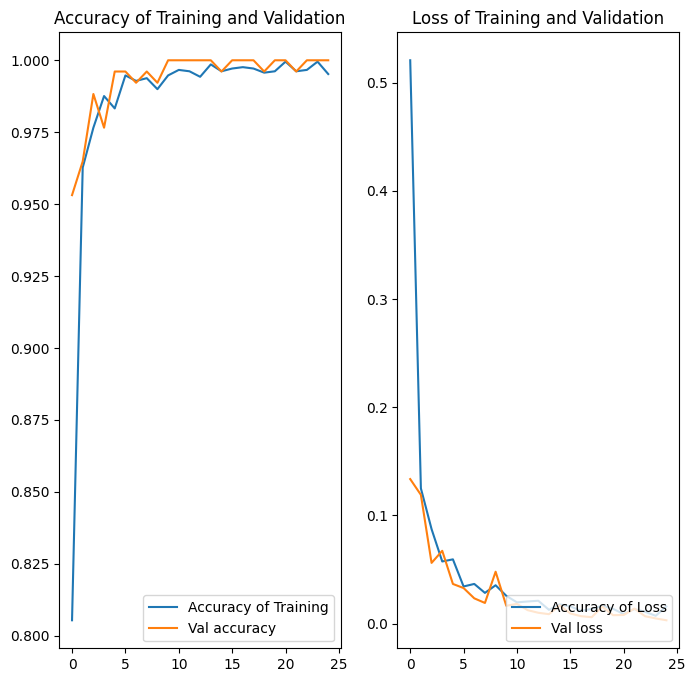

In [47]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_acc)), training_acc, label='Accuracy of Training')
plt.plot(range(len(val_acc)), val_acc, label='Val accuracy')
plt.legend(loc='lower right')
plt.title("Accuracy of Training and Validation")

plt.subplot(1, 2, 2)
plt.plot(range(len(training_loss)), training_loss, label='Accuracy of Loss')
plt.plot(range(len(val_loss)), val_loss, label='Val loss')
plt.legend(loc='lower right')
plt.title("Loss of Training and Validation")

plt.show()

In [48]:
import numpy as np

first image to predict
first image's actual label: Apple___Apple_scab
1/1 [==============================] - 0s 214ms/step
predicted label: Apple___Apple_scab


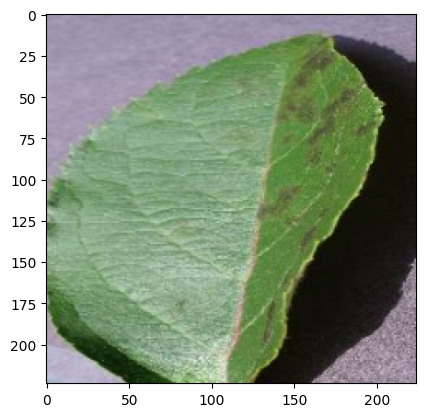

In [49]:
for images_batch , labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)

    print("first image's actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model , img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class , confidence

1/1 [==============================] - 0s 30ms/step


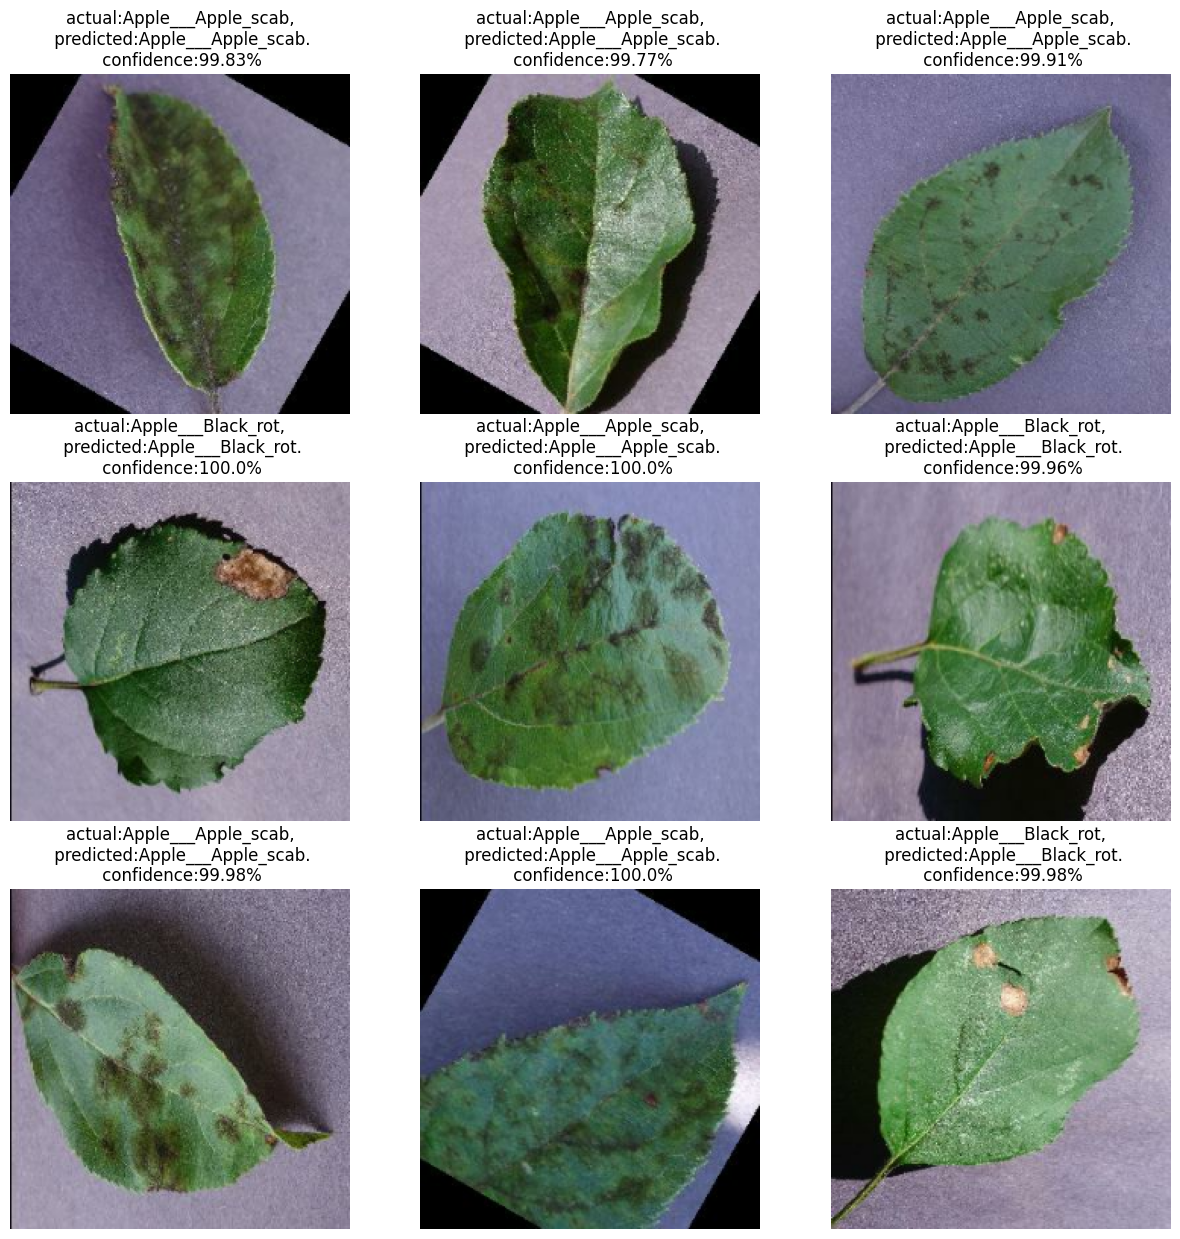

In [52]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model , images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"actual:{actual_class},\n predicted:{predicted_class}.\n confidence:{confidence}%")
        plt.axis('off')

In [53]:
model.save("Apple_vgg16.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/potato_vgg")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
with open("potato_vgg.tflite", "wb") as f:
    f.write(tflite_quant_model)

In [ ]:
!pip install tensorflow_model_optimization

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model

In [ ]:
model = load_model("potato_vgg16.h5")

# Define the pruning parameters
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                              final_sparsity=0.90,
                                                              begin_step=0,
                                                              end_step=int(len(train_ds) / BATCH_SIZE * EPOCHS),
                                                              frequency=100)
}

# Identify layers that can be pruned (layers with weights)
prunable_layers = [layer for layer in model.layers if hasattr(layer, 'kernel')]

# Remove non-prunable layers (e.g., Resizing layer) from the list
prunable_layers = [layer for layer in prunable_layers if not isinstance(layer, tf.keras.layers.experimental.preprocessing.Resizing)]

# Apply pruning to the prunable layers only
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_params, prunable_layers=prunable_layers)

# Compile the model after pruning
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

# Fine-tune the pruned model
pruning_callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_history = model_for_pruning.fit(train_ds,
                                       epochs=5,  # Adjust the number of epochs as needed
                                       batch_size=BATCH_SIZE,
                                       verbose=1,
                                       validation_data=val_ds,
                                       callbacks=pruning_callbacks)

# Evaluate the pruned model on the test set
pruned_scores = model_for_pruning.evaluate(test_ds)

# Save the pruned model
model_for_pruning.save("potato_vgg16_pruned.h5")

ValueError: ignored

In [ ]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                              final_sparsity=0.90,
                                                              begin_step=0,
                                                              end_step=int(len(train_ds) / BATCH_SIZE * EPOCHS),
                                                              frequency=100)
}

In [ ]:
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_params)

# Compile the model after pruning
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

# Fine-tune the pruned model
pruning_callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
]


ValueError: ignored

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-model-optimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
import tensorflow_model_optimization as tfmot

IMG_SIZE = 224
BATCH_SIZE = 32
Channels = 3
EPOCHS = 30
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, Channels)

# Load your dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "apple500",
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

vgg = tf.keras.applications.VGG16(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

n_classes = 3
model = Sequential()
model.add(resize_and_rescale)
model.add(data_agumentation)
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, Channels))

# Identify layers that can be pruned (layers with weights)
prunable_layers = [layer for layer in model.layers if hasattr(layer, 'kernel')]

# Remove non-prunable layers (e.g., Resizing layer) from the list
prunable_layers = [layer for layer in prunable_layers if not isinstance(layer, tf.keras.layers.experimental.preprocessing.Resizing)]

# Create a new model without non-prunable layers
pruned_model = Sequential(prunable_layers)

# Define the pruning parameters
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                              final_sparsity=0.90,
                                                              begin_step=0,
                                                              end_step=int(len(train_ds) / BATCH_SIZE * EPOCHS),
                                                              frequency=100)
}

# Apply pruning to the pruned model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(pruned_model, **pruning_params)

# Compile the pruned model
pruned_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Fine-tune the pruned model
pruning_callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_history = pruned_model.fit(
    train_ds,
    epochs=5,  # Adjust the number of epochs as needed
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

# Evaluate the pruned model on the test set
pruned_scores = pruned_model.evaluate(test_ds)

# Save the pruned model
pruned_model.save("potato_vgg16_pruned.h5")


Found 1520 files belonging to 3 classes.
Epoch 1/5


InvalidArgumentError: ignored